# Import packages

In [1]:
from deepface import DeepFace
#from common_functionality import *
import numpy as np
import contextlib
import os
import sys
from scipy.stats import entropy
from scipy.special import rel_entr
import pandas as pd
import cv2
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Saving functionality

## Emotion Classification

In [3]:
# Function that writes dominant emotion for a given survey image
def write_emotion_detected_survey(data_path, base_img_name, emotion_det):
    with open(data_path, 'r+') as f:
        processed_data = json.load(f)
        if 'imgs_list' in processed_data.keys():
            for index_f, frame in enumerate(processed_data['imgs_list']):
                if frame['img_num'] == base_img_name:
                    frame_dict = frame.copy()
                    frame_pos = index_f
                    break
            
            #print("Before:", roi_dict)
            frame_dict['emotion_classified'] = emotion_det
            #print("After:",roi_dict)

            processed_data['imgs_list'][frame_pos] = frame_dict
            f.seek(0)
            json.dump(processed_data, f, indent=4)
            f.truncate()  # This prevents leftover characters from previous write

# Function that write emotion probabilities for a given survey image
def write_emotion_probs_survey(data_path, base_img_name, emotion_probs):
    with open(data_path, 'r+') as f:
        processed_data = json.load(f)
        if 'imgs_list' in processed_data.keys():
            for index_f, frame in enumerate(processed_data['imgs_list']):
                if frame['img_num'] == base_img_name:
                    frame_dict = frame.copy()
                    frame_pos = index_f
                    break
            
            #print("Before:", roi_dict)
            frame_dict['emotion_probabilities'] = emotion_probs
            #print("After:",roi_dict)

            processed_data['imgs_list'][frame_pos] = frame_dict
            f.seek(0)
            json.dump(processed_data, f, indent=4)
            f.truncate()  # This prevents leftover characters from previous write

# Function which writes entropy from emotion probabilities for a given survey image
def write_emotion_entropy_survey(data_path, base_img_name, entropy_val):
    with open(data_path, 'r+') as f:
        processed_data = json.load(f)
        if 'imgs_list' in processed_data.keys():
            for index_f, frame in enumerate(processed_data['imgs_list']):
                if frame['img_num'] == base_img_name:
                    frame_dict = frame.copy()
                    frame_pos = index_f
                    break
            
            #print("Before:", roi_dict)
            frame_dict['entropy'] = entropy_val
            #print("After:",roi_dict)

            processed_data['imgs_list'][frame_pos] = frame_dict
            f.seek(0)
            json.dump(processed_data, f, indent=4)
            f.truncate()  # This prevents leftover characters from previous write

In [4]:
def predict_emotion(snapshot_path, snapshot_img_name, vid_emotion_categories, backend_detector):
    with suppress_stdout():
        result = DeepFace.analyze(snapshot_path, actions=['emotion'], detector_backend=backend_detector, enforce_detection=False)
    #result = DeepFace.analyze(snapshot_path, actions=['emotion'], detector_backend="yolov8", enforce_detection=False)

    # Initialise emotion category dictionary if empty
    if not bool(vid_emotion_categories):
        for category in result[0]['emotion'].keys():
            vid_emotion_categories[category] = []
    #         os.mkdir(os.path.join(imgs_path, category))
    emotion_displayed = result[0]['dominant_emotion']
    emotion_probs = result[0]['emotion']
    vid_emotion_categories[emotion_displayed].append(snapshot_img_name)
    emotion_probs_df = pd.DataFrame([emotion_probs])
    entropy_value = emotion_probs_df.apply(entropy, axis=1).iloc[0]

    return emotion_displayed, emotion_probs, entropy_value

## Parameter initialisation

In [7]:
rois_dir = os.path.join('..', 'survey_imgs')
video_data_path = os.path.join('..', 'survey_imgs_data', 'predictions', 'data.json')
results_path = os.path.join('..', 'survey_imgs_data', 'results')

if not os.path.exists(video_data_path):
    with open(video_data_path, 'w') as f:
        f.write(json.dumps({}))

if not os.path.exists(results_path):
    os.makedirs(results_path)

# Main execution

## Initialisation of Parameters for Reviewing Results after Execution

In [9]:
video_emotions_categorized = dict()
video_person_categorized = dict()

In [10]:
sorted_img_files = sorted([file for file in os.listdir(rois_dir)], key=lambda x: int(x.replace('.png', '')))

print(sorted_img_files)

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png', '101.pn

## Execution of Emotion Classification for survey images

In [13]:
for snapshot_img in sorted_img_files[0:1]:
    if snapshot_img.endswith('.jpg') or snapshot_img.endswith('.png'):
        base_img_name = os.path.splitext(snapshot_img)[0]
        snapshot_path = os.path.join(rois_dir, snapshot_img)
        try:
            snapshot_encodings = DeepFace.represent(snapshot_path, detector_backend='retinaface')
        except:
            print(f'No face detected in {snapshot_img}!')
            continue
            
        result = ''
        if len(snapshot_encodings) == 1:
            emotion_displayed, emotion_probs, entropy_value = predict_emotion(snapshot_path, snapshot_img, video_emotions_categorized, backend_detector='mtcnn')
            print(f'Emotion displayed in {snapshot_img}: {emotion_displayed}')
            print(f"Emotion Probabilties: {emotion_probs}")
            print(f"Entropy for {snapshot_img}: {entropy_value}")
            write_emotion_detected_survey(video_data_path, base_img_name, emotion_displayed.lower())
            write_emotion_probs_survey(video_data_path, base_img_name, emotion_probs)
            write_emotion_entropy_survey(video_data_path, base_img_name, entropy_value)
        else:
            highest_detected_confidence = -0.01
            best_encoding = None
            for encoding_index, encoding in enumerate(snapshot_encodings):
                if encoding['face_confidence'] > highest_detected_confidence:
                    highest_detected_confidence = encoding['face_confidence']
                    best_encoding = encoding
            
            snapshot_cv = cv2.imread(snapshot_path)

            roi_x = best_encoding['facial_area']['x']
            roi_y = best_encoding['facial_area']['y']
            roi_w = best_encoding['facial_area']['w']
            roi_h = best_encoding['facial_area']['h']
            roi_left, roi_right = roi_x, roi_x + roi_w
            roi_top, roi_bottom = roi_y, roi_y + roi_h

            if roi_top < 0:
                roi_top = 0
            
            if roi_left < 0:
                roi_left = 0

            snapshot_crop = snapshot_cv[roi_top:roi_bottom, roi_left:roi_right]
            emotion_displayed, emotion_probs, entropy_value = predict_emotion(snapshot_crop, snapshot_img, video_emotions_categorized, backend_detector='mtcnn')
            print(f'Emotion displayed in {snapshot_img}: {emotion_displayed}')
            print(f"Emotion Probabilties: {emotion_probs}")
            print(f"Entropy for {snapshot_img}: {entropy_value}")
            write_emotion_detected_survey(video_data_path, base_img_name, emotion_displayed.lower())
            write_emotion_probs_survey(video_data_path, base_img_name, emotion_probs)
            write_emotion_entropy_survey(video_data_path, base_img_name, entropy_value)
            print('-----------------------------------------------------------------------------------------------------------------')
print(f"Emotion Classification process for the survey sample images has finished!")

Emotion displayed in 1.png: neutral
Emotion Probabilties: {'angry': 0.16457997262477875, 'disgust': 3.742478115603687e-10, 'fear': 0.004030841591884382, 'happy': 1.098239792440836e-05, 'sad': 1.6485299915075302, 'surprise': 6.700075516619108e-06, 'neutral': 98.18283915519714}
Entropy for 1.png: 0.09664189504376552
Emotion Classification process for the survey sample images has finished!


In [30]:
for category, cat_list in video_emotions_categorized.items():
    print(category, '-', cat_list)

angry - ['frame_0009_00.png', 'frame_0010_00.png', 'frame_0013_00.png', 'frame_0015_00.png', 'frame_0016_00.png', 'frame_0027_00.png', 'frame_0028_00.png', 'frame_0029_01.png', 'frame_0033_00.png', 'frame_0034_00.png', 'frame_0044_00.png', 'frame_0052_00.png', 'frame_0055_00.png', 'frame_0056_00.png', 'frame_0067_00.png', 'frame_0073_00.png', 'frame_0080_00.png', 'frame_0082_00.png', 'frame_0086_00.png', 'frame_0089_00.png', 'frame_0092_00.png', 'frame_0093_00.png', 'frame_0095_00.png', 'frame_0096_01.png', 'frame_0097_00.png', 'frame_0101_00.png', 'frame_0103_00.png', 'frame_0104_00.png', 'frame_0105_00.png', 'frame_0107_00.png', 'frame_0108_00.png', 'frame_0109_00.png', 'frame_0110_01.png', 'frame_0116_00.png', 'frame_0117_00.png', 'frame_0125_00.png', 'frame_0126_00.png', 'frame_0131_00.png', 'frame_0138_00.png', 'frame_0139_00.png', 'frame_0141_00.png', 'frame_0143_00.png', 'frame_0143_01.png', 'frame_0145_00.png', 'frame_0146_00.png', 'frame_0149_00.png', 'frame_0151_00.png', 'fra

In [33]:
# Initialise list of arousal-valence values
emotion_av_values = {
    'happy': {'valence': 0.8, 'arousal': 0.7},
    'sad': {'valence': -0.6, 'arousal': -0.4},
    'neutral': {'valence': 0.0, 'arousal': 0.0},
    'angry': {'valence': -0.7, 'arousal': 0.6},
    'fear': {'valence': -0.6, 'arousal': 0.7},
    'surprise': {'valence': 0.4, 'arousal': 0.8},
    'disgust': {'valence': -0.7, 'arousal': 0.3}
}

# Open the file once and do everything inside the block
with open(video_data_path, 'r+') as file:
    video_data = json.load(file)

    # Update frames with predicted arousal and valence
    for frame in video_data.get('imgs_list', []):
        emotion_probs = frame.get('emotion_probabilities')
        if not emotion_probs:
            continue

        arousal_predicted = 0
        valence_predicted = 0

        for emotion, prob in emotion_probs.items():
            if emotion in emotion_av_values:
                arousal_predicted += prob/100 * emotion_av_values[emotion]['arousal']
                valence_predicted += prob/100 * emotion_av_values[emotion]['valence']

        frame['predicted_arousal'] = arousal_predicted
        frame['predicted_valence'] = valence_predicted

    # Move cursor to start and overwrite the file
    file.seek(0)
    json.dump(video_data, file, indent=4)
    file.truncate()

# Converting prediction data files from JSON to CSV and saving them in a file

In [44]:
for data_file in ['yolov8_data', 'retinaface_data', 'mtcnn_data']:
    with open(f'../survey_imgs_data/predictions/{data_file}.json', 'r+') as file:
        test_data = json.load(file)

    df = pd.DataFrame(test_data)
    df['img_num'] = df['imgs_list'].apply(lambda x: x['img_num'])
    df['assigned_frame'] = df['imgs_list'].apply(lambda x: x['assigned_frame'])
    df['emotion_classified'] = df['imgs_list'].apply(lambda x: x['emotion_classified'])
    df['emotion_probabilities'] = df['imgs_list'].apply(lambda x: x['emotion_probabilities'])
    df['entropy'] = df['imgs_list'].apply(lambda x: x['entropy'])

    df = df.drop(columns=['imgs_list'])

    df.to_csv(f'../survey_imgs_data/{data_file}_table.csv', index=False)


In [52]:
for data_file in ['yolov8_data', 'retinaface_data', 'mtcnn_data']:
    with open(f'../survey_imgs_data/predictions/{data_file}.json', 'r+') as file:
        test_data = json.load(file)

    df = pd.DataFrame(test_data)
    df['img_num'] = df['imgs_list'].apply(lambda x: x['img_num'])
    df['assigned_frame'] = df['imgs_list'].apply(lambda x: x['assigned_frame'])
    df['emotion_classified'] = df['imgs_list'].apply(lambda x: x['emotion_classified'])
    df['emotion_probabilities'] = df['imgs_list'].apply(lambda x: x['emotion_probabilities'])
    df['entropy'] = df['imgs_list'].apply(lambda x: x['entropy'])

    df = df.drop(columns=['imgs_list'])

    for emotion_label in ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']:
        df[emotion_label] = df['emotion_probabilities'].apply(lambda x: x[emotion_label])

    df = df.drop(columns=['emotion_probabilities'])
    df.to_csv(f'../survey_imgs_data/predictions/{data_file}_distribution.csv', index=False)


# Computing KL Divergence values

In [2]:
# Function which computes the average KL divergence across all survey images
def compute_avg_kl(merged_df, emotion_cols, suffix):
    human_dist = merged_df[[f'{emo}_human' for emo in emotion_cols]].values
    pred_dist = merged_df[[f'{emo}_{suffix}' for emo in emotion_cols]].values
    
    epsilon = 1e-10
    human_dist = np.clip(human_dist, epsilon, 1)
    pred_dist = np.clip(pred_dist, epsilon, 1)
    
    human_dist = human_dist / human_dist.sum(axis=1, keepdims=True)
    pred_dist = pred_dist / pred_dist.sum(axis=1, keepdims=True)
    
    kl_divs = np.sum(rel_entr(human_dist, pred_dist), axis=1)
    return np.mean(kl_divs)

# Function which computes KL divergence for each one of the survey images
def compute_kl_per_image(merged_df,emotion_cols, suffix):
    human_dist = merged_df[[f'{emo}_human' for emo in emotion_cols]].values
    pred_dist = merged_df[[f'{emo}_{suffix}' for emo in emotion_cols]].values

    epsilon = 1e-10
    human_dist = np.clip(human_dist, epsilon, 1)
    pred_dist = np.clip(pred_dist, epsilon, 1)

    human_dist = human_dist / human_dist.sum(axis=1, keepdims=True)
    pred_dist = pred_dist / pred_dist.sum(axis=1, keepdims=True)

    kl_divs = np.sum(rel_entr(human_dist, pred_dist), axis=1)
    return pd.DataFrame({
        'image_id': merged_df['image_id'],
        f'kl_divergence_{suffix}': kl_divs
    })

In [3]:
# Loading annotations and predictions
human_annotations = pd.read_csv("../survey_imgs_data/annotations/image_emotion_entropy.csv")
retinaface_pred = pd.read_csv("../survey_imgs_data/predictions/retinaface_data_distribution.csv")
yolov8_pred = pd.read_csv("../survey_imgs_data/predictions/yolov8_data_distribution.csv")
mtcnn_pred = pd.read_csv("../survey_imgs_data/predictions/mtcnn_data_distribution.csv")

# Emotion columns
emotion_cols = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Normalize backend distributions
for backend in [retinaface_pred, yolov8_pred, mtcnn_pred]:
    backend[emotion_cols] = backend[emotion_cols] / 100

# Rename 'img_num' in backend files to match 'image_id'
retinaface_pred = retinaface_pred.rename(columns={'img_num': 'image_id'})
yolov8_pred = yolov8_pred.rename(columns={'img_num': 'image_id'})
mtcnn_pred = mtcnn_pred.rename(columns={'img_num': 'image_id'})

# Merge backend data with human annotations
retina_merged = pd.merge(human_annotations, retinaface_pred, on='image_id', suffixes=('_human', '_retinaface'))
yolo_merged = pd.merge(human_annotations, yolov8_pred, on='image_id', suffixes=('_human', '_yolov8'))
mtcnn_merged = pd.merge(human_annotations, mtcnn_pred, on='image_id', suffixes=('_human', '_mtcnn'))

# Compute KL divergence for each backend
kl_retina = compute_avg_kl(retina_merged, emotion_cols, 'retinaface')
kl_yolo = compute_avg_kl(yolo_merged, emotion_cols, 'yolov8')
kl_mtcnn = compute_avg_kl(mtcnn_merged, emotion_cols, 'mtcnn')

print(f"Average KL Divergence (RetinaFace): {kl_retina}")
print(f"Average KL Divergence (YOLOv8): {kl_yolo}")
print(f"Average KL Divergence (MTCNN): {kl_mtcnn}")

Average KL Divergence (RetinaFace): 4.227950474938731
Average KL Divergence (YOLOv8): 3.7405353633387466
Average KL Divergence (MTCNN): 3.943655412497355


In [4]:
# Compute KL divergence for each backend
kl_retina = compute_kl_per_image(retina_merged, emotion_cols, 'retinaface')
kl_yolo = compute_kl_per_image(yolo_merged, emotion_cols, 'yolov8')
kl_mtcnn = compute_kl_per_image(mtcnn_merged, emotion_cols, 'mtcnn')

# Combine into one DataFrame
kl_all = kl_retina.merge(kl_yolo, on='image_id').merge(kl_mtcnn, on='image_id')

print(kl_all.to_string())

     image_id  kl_divergence_retinaface  kl_divergence_yolov8  kl_divergence_mtcnn
0           1                  0.065111              0.505156             0.891923
1           2                  4.725551              3.243206             2.916131
2           3                  4.205280              1.428008             2.069540
3           4                  1.663933              1.698753             1.869939
4           5                  3.028397              2.307052             2.967738
5           6                  5.977027              5.861118             6.039674
6           7                  7.683466              8.650394             6.407472
7           8                  2.609472              1.689496             1.861974
8           9                  4.323331              4.848340             4.218237
9          10                  8.382714              7.495084             8.188981
10         11                  3.223495              1.608566             4.356531
11  

In [18]:
kl_all.to_csv(f'../survey_imgs_data/results/kl_divergence_table.csv', index=False)

## Generating graph for Average KL Divergence by Emotion and Backend Detector

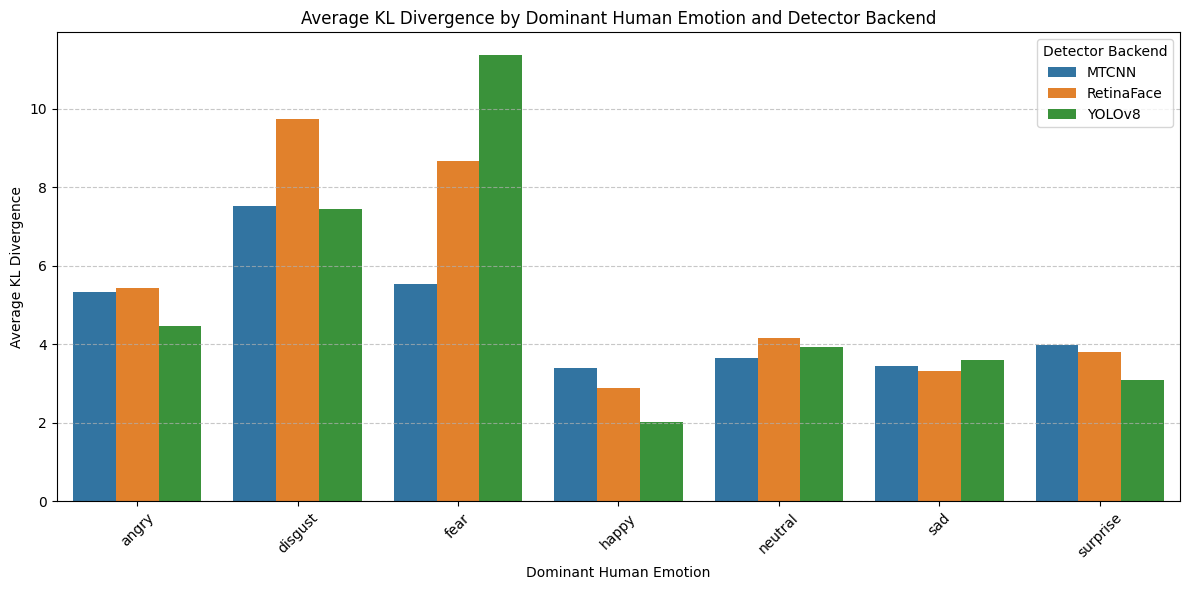

In [5]:
# Add dominant emotion to human annotations table
def get_dominant_emotion(row):
    return row[emotion_cols].idxmax()

human_annotations['dominant_emotion'] = human_annotations.apply(get_dominant_emotion, axis=1)
kl_all_emotions = kl_all.merge(human_annotations[['image_id', 'dominant_emotion']], on='image_id')

# Reshape for visualization
kl_melted = kl_all_emotions.melt(id_vars=['image_id', 'dominant_emotion'],
                                  value_vars=['kl_divergence_retinaface', 'kl_divergence_yolov8', 'kl_divergence_mtcnn'],
                                  var_name='backend', value_name='kl_divergence')

# Calculate mean KL divergence by emotion and backend
kl_mean_by_emotion = kl_melted.groupby(['dominant_emotion', 'backend'])['kl_divergence'].mean().reset_index()

kl_mean_by_emotion['backend'] = kl_mean_by_emotion['backend'].replace({
    'kl_divergence_retinaface': 'RetinaFace',
    'kl_divergence_yolov8': 'YOLOv8',
    'kl_divergence_mtcnn': 'MTCNN'
})

# Plot a bar chart showcasing average KL divergence by emotion and detector
plt.figure(figsize=(12, 6))
sns.barplot(data=kl_mean_by_emotion, x='dominant_emotion', y='kl_divergence', hue='backend')
plt.title('Average KL Divergence by Dominant Human Emotion and Detector Backend')
plt.xlabel('Dominant Human Emotion')
plt.ylabel('Average KL Divergence')
plt.xticks(rotation=45)
plt.legend(title='Detector Backend')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Computing entropy by detector backend and emotion label

In [6]:
# Load entropy values from each backend's original dataframe
retinaface_entropy = retinaface_pred[['image_id', 'entropy']].rename(columns={'entropy': 'entropy_retinaface'})
yolov8_entropy = yolov8_pred[['image_id', 'entropy']].rename(columns={'entropy': 'entropy_yolov8'})
mtcnn_entropy = mtcnn_pred[['image_id', 'entropy']].rename(columns={'entropy': 'entropy_mtcnn'})

# Merge entropy values into one DataFrame
entropy_all = retinaface_entropy.merge(yolov8_entropy, on='image_id').merge(mtcnn_entropy, on='image_id')

# Merge with dominant emotion labels from human annotations
entropy_all = entropy_all.merge(human_annotations[['image_id', 'dominant_emotion']], on='image_id')

# Compute overall mean entropy per backend
overall_entropy = entropy_all[['entropy_retinaface', 'entropy_yolov8', 'entropy_mtcnn']].mean()

display(overall_entropy)

entropy_retinaface    0.573890
entropy_yolov8        0.649841
entropy_mtcnn         0.618820
dtype: float64

In [7]:
# Compute mean entropy per emotion per backend
entropy_by_emotion = entropy_all.groupby('dominant_emotion')[
    ['entropy_retinaface', 'entropy_yolov8', 'entropy_mtcnn']
].mean().reset_index()

display(entropy_by_emotion)

,dominant_emotion,entropy_retinaface,entropy_yolov8,entropy_mtcnn
0,angry,0.606283,0.794109,0.603309
1,disgust,0.825787,0.698758,0.797556
2,fear,0.086006,0.052406,0.932203
3,happy,0.338203,0.426430,0.417654
4,neutral,0.602910,0.680408,0.672813
5,sad,0.627189,0.683448,0.740917
6,surprise,0.727198,0.773852,0.509271


## Generating graph for Average Entropy by Emotion and Detector Backend

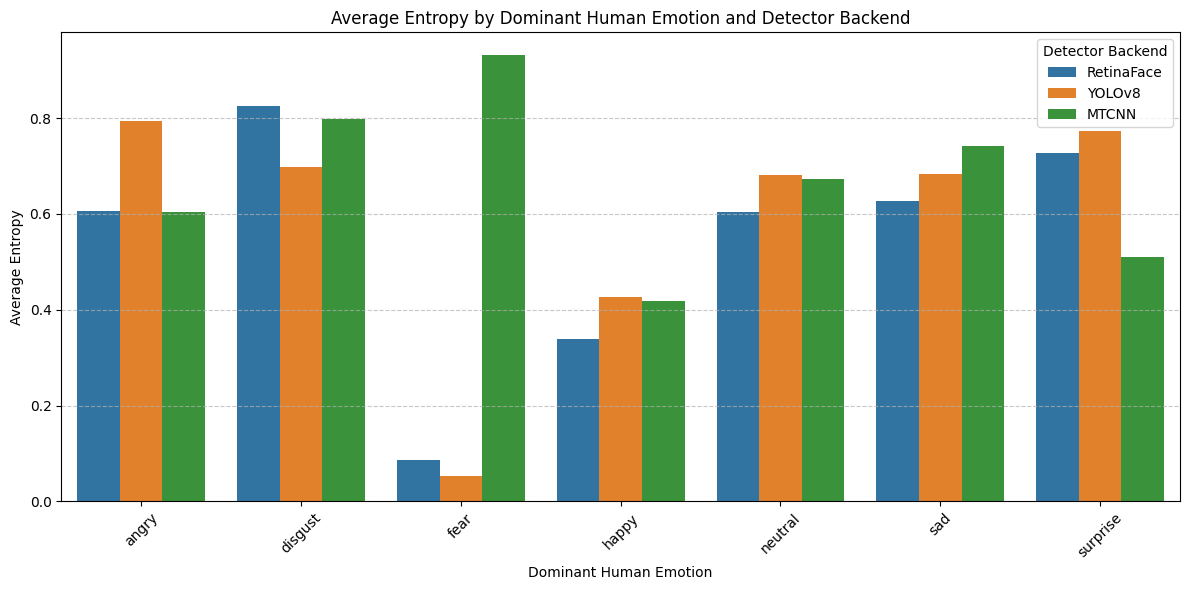

In [8]:
# Reshape the entropy_by_emotion dataframe for plotting
entropy_melted = entropy_by_emotion.melt(id_vars='dominant_emotion',
                                         value_vars=['entropy_retinaface', 'entropy_yolov8', 'entropy_mtcnn'],
                                         var_name='backend', value_name='entropy')

entropy_melted['backend'] = entropy_melted['backend'].replace({
    'entropy_retinaface': 'RetinaFace',
    'entropy_yolov8': 'YOLOv8',
    'entropy_mtcnn': 'MTCNN'
})

# Plot a bar chart of average entropy by emotion and backend
plt.figure(figsize=(12, 6))
sns.barplot(data=entropy_melted, x='dominant_emotion', y='entropy', hue='backend')
plt.title('Average Entropy by Dominant Human Emotion and Detector Backend')
plt.xlabel('Dominant Human Emotion')
plt.ylabel('Average Entropy')
plt.xticks(rotation=45)
plt.legend(title='Detector Backend')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Generating per image graphs for entropy and KL divergence

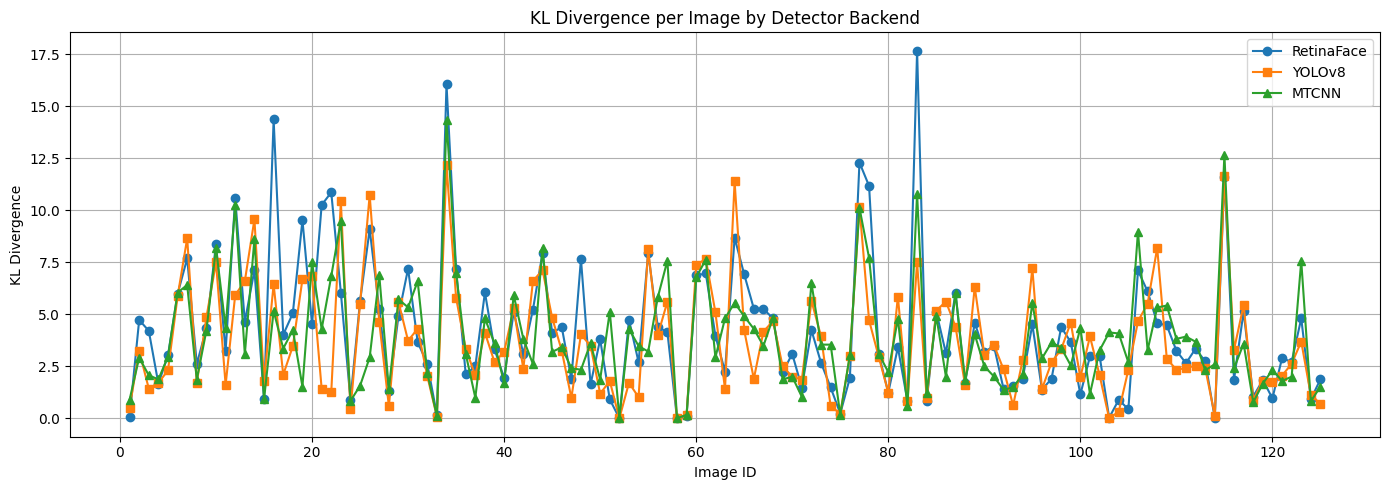

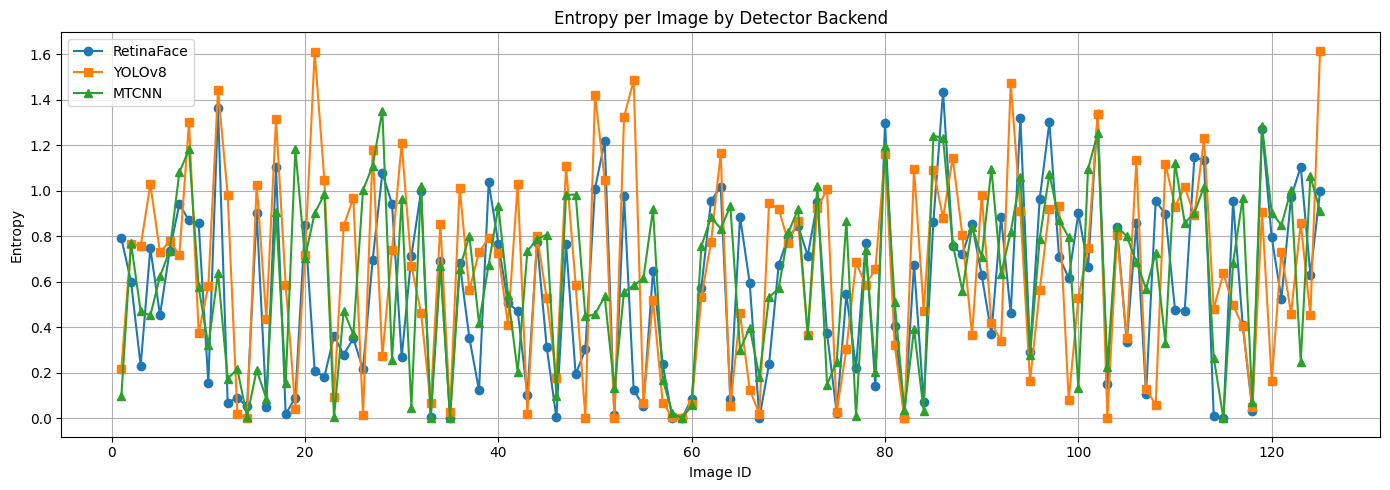

In [9]:
# Sort data by image_id for line plot consistency
kl_line = kl_all.sort_values(by='image_id')
entropy_line = entropy_all.sort_values(by='image_id')

# Line plot for KL divergence per image
plt.figure(figsize=(14, 5))
plt.plot(kl_line['image_id'], kl_line['kl_divergence_retinaface'], label='RetinaFace', marker='o')
plt.plot(kl_line['image_id'], kl_line['kl_divergence_yolov8'], label='YOLOv8', marker='s')
plt.plot(kl_line['image_id'], kl_line['kl_divergence_mtcnn'], label='MTCNN', marker='^')
plt.title('KL Divergence per Image by Detector Backend')
plt.xlabel('Image ID')
plt.ylabel('KL Divergence')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Line plot for Entropy per image
plt.figure(figsize=(14, 5))
plt.plot(entropy_line['image_id'], entropy_line['entropy_retinaface'], label='RetinaFace', marker='o')
plt.plot(entropy_line['image_id'], entropy_line['entropy_yolov8'], label='YOLOv8', marker='s')
plt.plot(entropy_line['image_id'], entropy_line['entropy_mtcnn'], label='MTCNN', marker='^')
plt.title('Entropy per Image by Detector Backend')
plt.xlabel('Image ID')
plt.ylabel('Entropy')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()